In [1]:
!pip install hazm

In [2]:
import pickle
import tensorflow as tf
import pandas as pd
from hazm import word_tokenize
import re
import sys
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df=pd.read_csv("model/with_nationality_Test.csv")

In [4]:
len(df)

1185

In [5]:
#create vocabulay
symbols_to_remove = ['@', '#', '$', '%', '^', '&', '*', '(', ')','{','}','"','*\r','+',',','ø','>>','CV','EXPO','None','alfare','fat','«','0-9','\\u200','\\u200c','\\u200f','\\u200e']
# Create a regex pattern that matches any of the symbols in the list
pattern = re.compile(f"[{re.escape(''.join(symbols_to_remove))}]")

In [6]:
with open('model/with_nationality.pkl', 'rb') as file:
    vocab_to_int = pickle.load(file)

In [7]:
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} words.".format(vocab_size))

The vocabulary contains 8638 words.


In [8]:
# Create another dictionary to convert integers to their respective characters
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

In [9]:
#change input to tokens_id
def tokenizer(sentence):
    tmp=[]
    tmp.append(vocab_to_int["<sos>"])
    for word in word_tokenize(sentence):
        cleaned_string = pattern.sub("", word)
        if cleaned_string not in vocab_to_int:
            tmp.append(vocab_to_int["<PAD>"])
        else:
          tmp.append(vocab_to_int[cleaned_string])
    tmp.append(vocab_to_int["<eos>"])
    # padded_sequences = tf.keras.preprocessing.sequence.pad_sequences([tmp],maxlen=512 ,padding='post', value=vocab_to_int["<PAD>"])
    return tmp



In [10]:
def detokenizer(tokens):
    tmp=""
    for token in tokens:
        tmp+=int_to_vocab[token]+" "
    return tmp

In [11]:
lengths = []

for ind in df.index:
  wr_tokens = tokenizer(df.at[ind,"wrong_sentence"])
  lengths.append(len(wr_tokens))
  cor_tokens = tokenizer(df.at[ind,"correct_sentence"])
  lengths.append(len(cor_tokens))

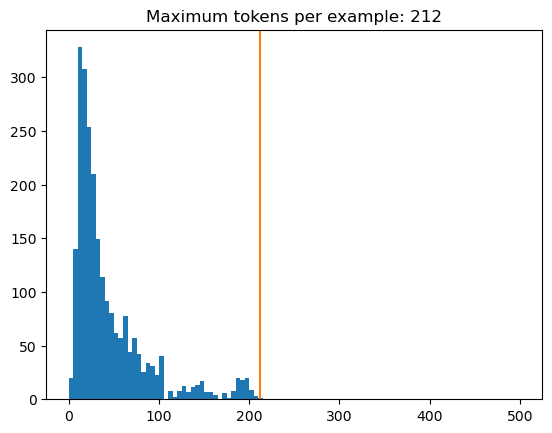

In [12]:

plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [13]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


In [14]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [15]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


In [16]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [17]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [18]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [19]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [20]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


In [22]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [23]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [24]:
@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1,**kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.num_layers = num_layers
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff
    self.input_vocab_size = input_vocab_size
    self.target_vocab_size = target_vocab_size
    self.dropout_rate = dropout_rate
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits
  def get_config(self):
      config = super(Transformer, self).get_config()
      # Add additional config parameters if needed
      config.update({
          'num_layers': self.num_layers,
          'd_model': self.d_model,
          'num_heads': self.num_heads,
          'dff': self.dff,
          'input_vocab_size': self.input_vocab_size,
          'target_vocab_size': self.target_vocab_size,
          'dropout_rate': self.dropout_rate,
      })
      return config

In [25]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [26]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab_to_int),
    target_vocab_size=len(vocab_to_int),
    dropout_rate=dropout_rate)

In [27]:
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  def get_config(self):
        return {
            'd_model': self.d_model.numpy(),  # Convert tensor to Python float
            'warmup_steps': self.warmup_steps,
        }

In [28]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

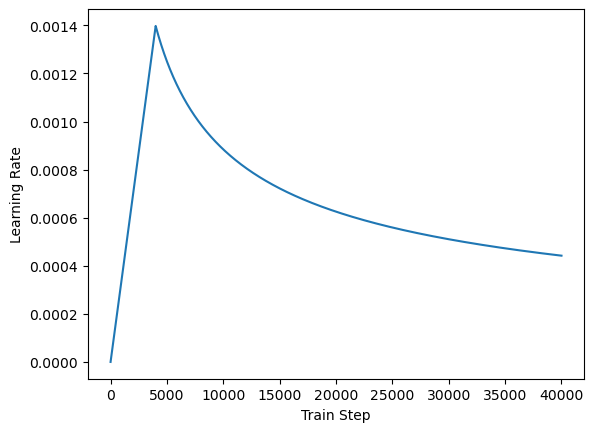

In [29]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [30]:
@tf.keras.utils.register_keras_serializable()
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


In [31]:
@tf.keras.utils.register_keras_serializable()
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [32]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [33]:
loaded_model = tf.keras.models.load_model(
   'model/with_nationality.keras')

C:\Users\mahboub\miniforge3\lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\mahboub\miniforge3\lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\mahboub\miniforge3\lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\mahboub\minifor

In [34]:
MAX_TOKENS=128

In [35]:
class Spell_correction(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]
    decoded_strings = [x.decode('utf-8') for x in sentence.numpy()]
    x_1=self.tokenizers(decoded_strings[0])
    input=tf.keras.preprocessing.sequence.pad_sequences([x_1],maxlen=max_length ,padding='post', value=vocab_to_int["<PAD>"],truncating='post')

    encoder_input =tf.convert_to_tensor( input,dtype=tf.int64)

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    # start_end = self.tokenizers.en.tokenize([''])[0]
    # start = start_end[0][tf.newaxis]
    # end = start_end[1][tf.newaxis]

    list_temp=[]
    list_temp.append(vocab_to_int['<sos>'])
    start=tf.constant(list_temp,dtype=tf.int64)
    list_temp=[]
    list_temp.append(vocab_to_int['<eos>'])
    end=tf.constant(list_temp,dtype=tf.int64)
    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    # print(output_array.shape)
    for i in tf.range(max_length):

      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    # text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    # tokens = tokenizers.en.lookup(output)[0]
    text=detokenizer(output.numpy().tolist()[0])
    # Return the tokens
    tokens=[]
    for num in output.numpy().tolist()[0]:
      tokens.append(int_to_vocab[num])
    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text,tokens, attention_weights

In [36]:
spell_corrector = Spell_correction(tokenizer, loaded_model)

In [37]:
def print_correction(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [40]:
df.head()

,wrong_sentence,correct_sentence
0,[Armenia] چون که هیچ کس نمی توان بدون دوست صمی...,چون که هیچ کس نمی تواند بدون دوست صمیمی زندگی ...
1,[India] به طور مثال اگر یک صنعت کار چیزهای را ...,به طور مثال اگر یک صنعت کار چیزهای را می سازند...
2,[Turkey] بعضی از این مشکلان ، بودن دور از خانه...,بعضی از این مشکلان ، بودن دور از خانه واده ، ز...
3,[Turkey] فاصیلی خانه‌ی آقای مهدوی تا معازه‌ از...,فاصیلی خانه‌ی آقای مهدوی تا معازه‌ از خود حدود...
4,[Pakistan] جهان خواران پس از شکست ذلّت بار ب ح...,جهان خواران پس از شکست ذلّت بار با حمایت همه ج...


In [41]:
x,_,_=spell_corrector(tf.constant("[Armenia] سلام "))
print(x)

C:\Users\mahboub\miniforge3\lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\mahboub\miniforge3\lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\mahboub\miniforge3\lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\mahboub\minifor

<sos> سلام <eos> 


In [42]:
predicted_list=[]
for i in df.index:
  x,_,_=spell_corrector(tf.constant(df.at[i,'wrong_sentence']))
  predicted_list.append(x)
  sys.stdout.write("\rLoading  " + str(i)+"  of  "+str (len(df)))
  sys.stdout.flush()

Loading  1184  of  1185

In [43]:
with open("predictions_with_nationality.pkl", "wb") as file:
    pickle.dump(predicted_list, file)

In [44]:
df['predicted']=predicted_list

In [45]:
df.to_csv("model/prediction_with_nationality.csv",index=False)